In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")



In [6]:
df = pd.read_excel('/content/drive/MyDrive/walmart Retail Data (1).xlsx')
df

,City,Customer Age,Customer Name,Customer Segment,Discount,Number of Records,Order Date,Order ID,Order Priority,Order Quantity,...,Profit,Region,Row ID,Sales,Ship Date,Ship Mode,Shipping Cost,State,Unit Price,Zip Code
0,McKeesport,NaN,Jessica Myrick,Small Business,0.10,1,2012-01-01,28774,High,32,...,-111.80,East,4031,180.36,2012-01-02,Regular Air,4.69,Pennsylvania,5.98,15131
1,Bowie,NaN,Matt Collister,Home Office,0.08,1,2012-01-01,13729,Not Specified,9,...,-342.91,East,1914,872.48,2012-01-03,Express Air,35.00,Maryland,95.99,20715
2,Napa,NaN,Alan Schoenberger,Corporate,0.00,1,2012-01-02,37537,Low,4,...,-193.08,West,5272,1239.06,2012-01-02,Delivery Truck,48.80,California,291.73,94559
3,Montebello,NaN,Elizabeth Moffitt,Consumer,0.08,1,2012-01-02,44069,Critical,43,...,247.79,West,6225,614.80,2012-01-02,Regular Air,1.97,California,15.04,90640
4,Napa,NaN,Alan Schoenberger,Corporate,0.07,1,2012-01-02,37537,Low,43,...,-1049.85,West,5273,4083.19,2012-01-04,Delivery Truck,45.00,California,100.98,94559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,Fairfield,95.0,Tony Molinari,Corporate,0.10,1,2015-12-30,50950,Not Specified,35,...,-15.07,West,7142,448.10,2015-12-30,Express Air,4.51,California,13.48,94533
8395,Harker Heights,95.0,Matt Hagelstein,Home Office,0.09,1,2015-12-30,25542,Low,37,...,-18.66,Central,3583,257.46,2015-12-30,Express Air,4.23,Texas,7.28,76543
8396,Riverview,95.0,Theresa Swint,Consumer,0.10,1,2015-12-30,45127,Medium,10,...,-1.29,South,6361,14.15,2015-12-30,Regular Air,0.70,Florida,1.48,33569
8397,Nicholasville,95.0,Maribeth Yedwab,Home Office,0.09,1,2015-12-30,49344,Low,1,...,-745.20,South,6916,803.33,2015-12-30,Regular Air,24.49,Kentucky,832.81,40356


In [5]:
df.head()

,City,Customer Age,Customer Name,Customer Segment,Discount,Number of Records,Order Date,Order ID,Order Priority,Order Quantity,...,Profit,Region,Row ID,Sales,Ship Date,Ship Mode,Shipping Cost,State,Unit Price,Zip Code
0,McKeesport,NaN,Jessica Myrick,Small Business,0.10,1,2012-01-01,28774,High,32,...,-111.80,East,4031,180.36,2012-01-02,Regular Air,4.69,Pennsylvania,5.98,15131
1,Bowie,NaN,Matt Collister,Home Office,0.08,1,2012-01-01,13729,Not Specified,9,...,-342.91,East,1914,872.48,2012-01-03,Express Air,35.00,Maryland,95.99,20715
2,Napa,NaN,Alan Schoenberger,Corporate,0.00,1,2012-01-02,37537,Low,4,...,-193.08,West,5272,1239.06,2012-01-02,Delivery Truck,48.80,California,291.73,94559
3,Montebello,NaN,Elizabeth Moffitt,Consumer,0.08,1,2012-01-02,44069,Critical,43,...,247.79,West,6225,614.80,2012-01-02,Regular Air,1.97,California,15.04,90640
4,Napa,NaN,Alan Schoenberger,Corporate,0.07,1,2012-01-02,37537,Low,43,...,-1049.85,West,5273,4083.19,2012-01-04,Delivery Truck,45.00,California,100.98,94559


In [7]:
order_date=df['Order Date'].tolist()
sales_value=df['Sales'].tolist()
sales_data= pd.DataFrame({'Order Date':order_date,'Sales':sales_value})
sales_data['Order Date']=pd.to_datetime(sales_data['Order Date'])

sales_data.head()

,Order Date,Sales
0,2012-01-01,180.36
1,2012-01-01,872.48
2,2012-01-02,1239.06
3,2012-01-02,614.80
4,2012-01-02,4083.19


In [11]:
'''df['Order Date'] = pd.to_datetime(df['Order Date'])
df.set_index('Order Date', inplace=True)
monthly_sales = df.resample('M').mean()
monthly_sales.head()'''
df1 = sales_data.set_index('Order Date')

monthly_sales = df1.resample('M').mean()
monthly_sales.head()

,Sales
Order Date,
2012-01-31,2315.259908
2012-02-29,2187.372609
2012-03-31,2225.020157
2012-04-30,2286.491174
2012-05-31,1264.535923


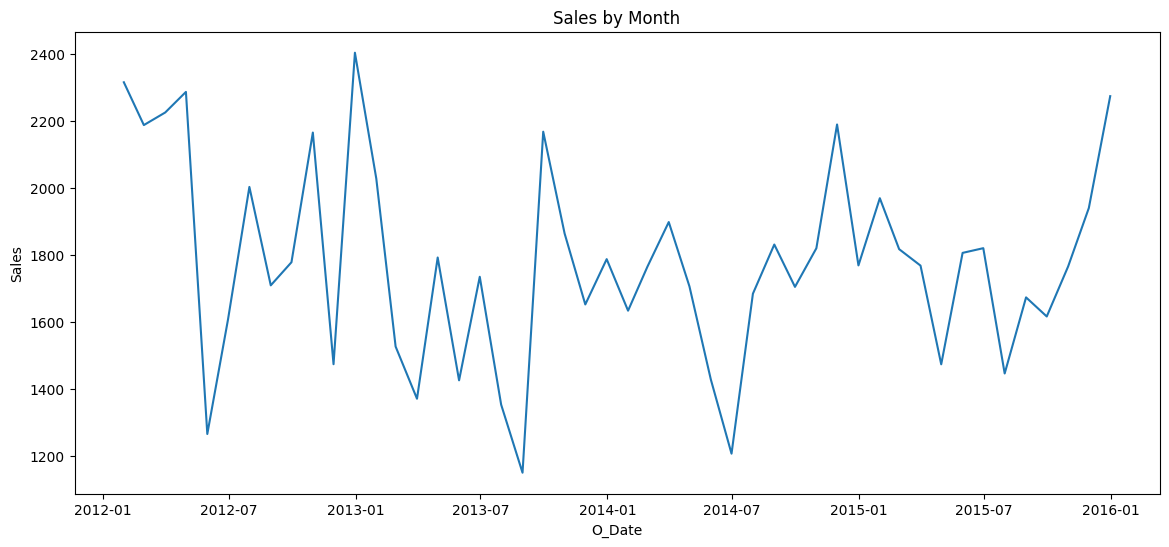

In [12]:

plt.figure(figsize=(14,6))
plt.plot(monthly_sales)
plt.title("Sales by Month")
plt.xlabel("O_Date")
plt.ylabel("Sales")
plt.show()

**To Check Data Stationary**

In [15]:

'''def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')'''
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(monthly_sales['Sales'])

ADF Statistic: -5.606134546731689
p-value: 1.2330385337321382e-06
Stationary


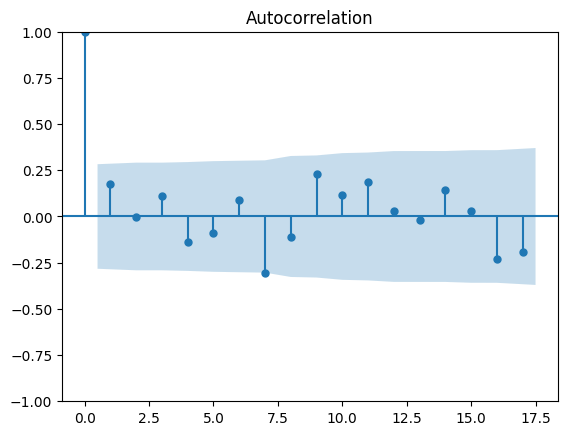

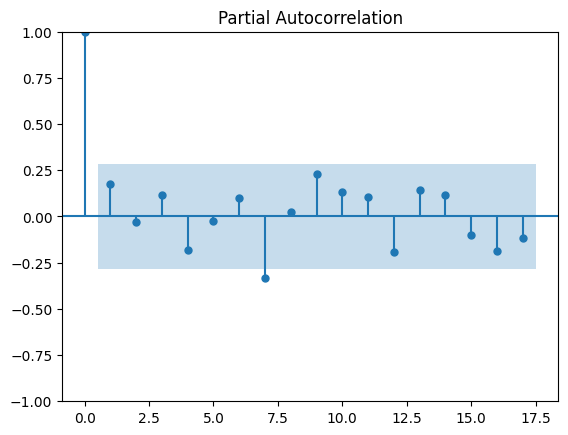

In [16]:
plot_acf(monthly_sales)
plot_pacf(monthly_sales)
plt.show()


In [17]:

p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 12

model = SARIMAX(monthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

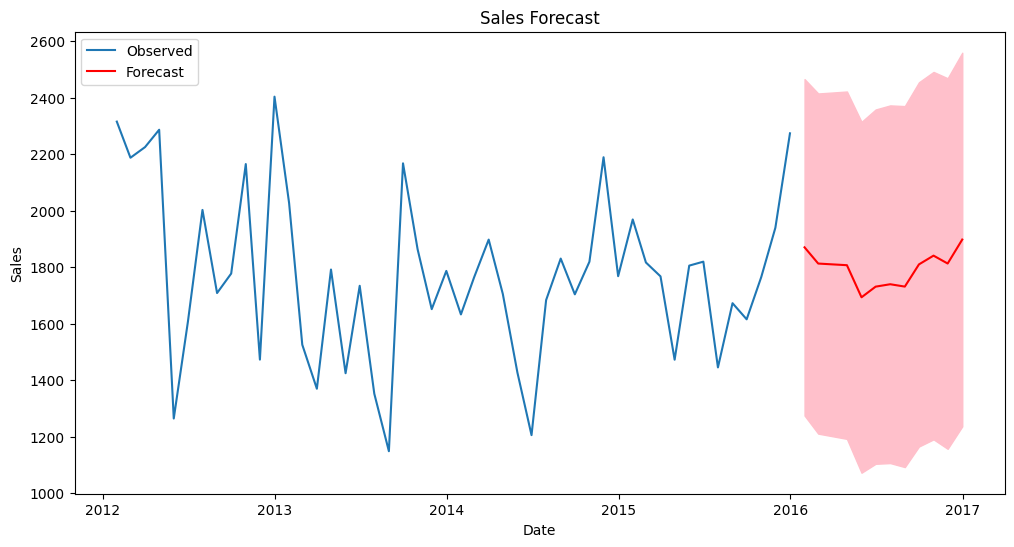

In [18]:
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [19]:

observed = monthly_sales[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')


MAE: 150.45424606056346
MSE: 36228.68831850669
